- # 05 – Pipeline and Monitoring for Anomaly Detection

## Objective

Design a **production-grade anomaly detection pipeline** that:

* Supports unsupervised and semi-supervised anomaly models
* Enforces strict separation between training, inference, and monitoring
* Detects **data drift**, **score drift**, and **concept decay**
* Is suitable for fraud, abuse, operational risk, or system health use cases

Anomaly detection here is treated as a **continuous surveillance system**, not a one-off model.

---

## Pipeline Design Principles

- ✔ No label dependency at inference time
- ✔ Feature generation identical in training and serving
- ✔ Thresholds treated as controllable decision parameters
- ✔ Monitoring is mandatory, not optional

---

## High-Level Architecture

```
Raw Events / Transactions
        ↓
Feature Engineering (Deterministic)
        ↓
Anomaly Scoring Model
        ↓
Thresholding / Ranking
        ↓
Alerts / Review Queue
        ↓
Monitoring & Retraining
```

---

## Imports and Setup

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

## Dataset Assumptions

* Tabular transaction-style data
* Mostly unlabeled (optional `is_fraud` for evaluation only)
* Anomalies are rare (< 1–2%)

In [77]:
DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Anomaly-fraud-detection"
df = pd.read_csv(DATA_PATH + '/' + 'data.csv')

df.head()

,log_amount,tx_count_1h,tx_count_24h,amount_sum_1h,amount_vs_user_mean,is_fraud
0,2.894296,4,8,147.751332,1.741961,0
1,2.490703,1,3,258.166718,0.042524,0
2,3.734484,0,4,117.667634,1.491628,0
3,2.979201,1,3,55.274887,0.968212,0
4,0.583843,2,10,95.122333,0.627956,0


In [81]:
FEATURES = [c for c in df.columns if c not in ["is_fraud", "timestamp"]]

##  Deterministic Feature Pipeline

In [84]:
feature_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

X = feature_pipeline.fit_transform(df[FEATURES])

 **Critical rule**: Feature logic must be frozen after deployment.

##  Anomaly Detection Model

In [88]:
model = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42
)

model.fit(X)

IsolationForest(contamination=0.01, n_estimators=300, random_state=42)

Isolation Forest produces **relative anomaly scores**, not probabilities.



##  Anomaly Scoring & Thresholding

In [91]:
anomaly_scores = -model.decision_function(X)
df["anomaly_score"] = anomaly_scores

Higher score ⇒ more anomalous

### Threshold Selection (Percentile-Based)

In [94]:
threshold = np.percentile(df["anomaly_score"], 99)

df["is_anomaly"] = (df["anomaly_score"] >= threshold).astype(int)

Thresholds should be:

* Business-controlled
* Stable over time
* Versioned

## Offline Evaluation (If Labels Exist)

In [98]:
if "is_fraud" in df.columns:
    auc = roc_auc_score(df["is_fraud"], df["anomaly_score"])
    print("ROC-AUC:", auc)

ROC-AUC: 0.5186626045552809


 ROC-AUC is **diagnostic**, not an operating metric.


## Monitoring Strategy

### 1. Score Drift Monitoring

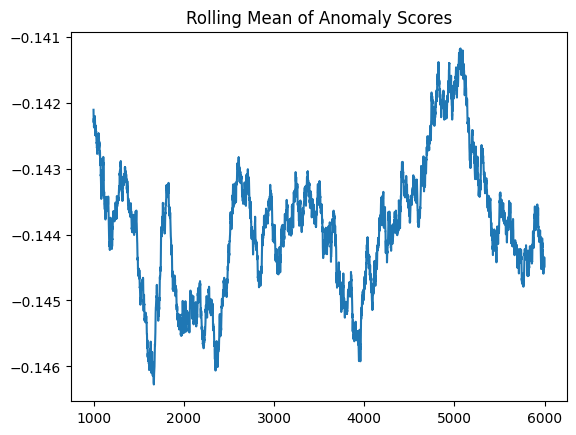

In [101]:
df["anomaly_score"].rolling(1000).mean().plot(title="Rolling Mean of Anomaly Scores")
plt.show()

Watch for:

* Upward drift → system degradation
* Downward collapse → model desensitization

### 2. Alert Volume Monitoring

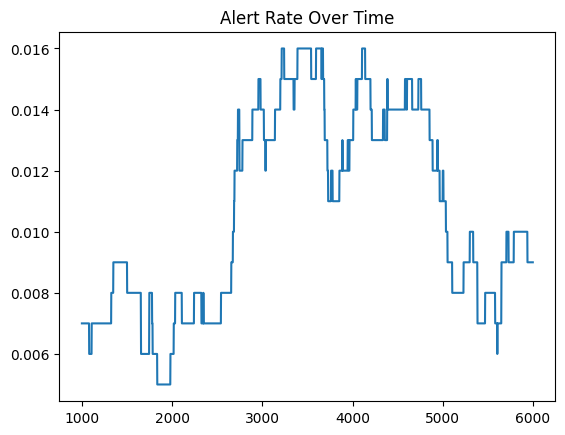

In [105]:
df["is_anomaly"].rolling(1000).mean().plot(title="Alert Rate Over Time")
plt.show()

Alert rate should be:

* Predictable
* Bounded
* Capacity-aware

### 3. Feature Distribution Drift

In [109]:
df[FEATURES].describe().T[["mean", "std"]]

,mean,std
log_amount,3.003970,0.993341
tx_count_1h,2.007833,1.425638
tx_count_24h,4.962833,2.223798
amount_sum_1h,100.204362,100.024555
amount_vs_user_mean,1.007423,0.503924


In production, compare:

* Training vs current windows
* PSI / KS statistics (recommended)

## Inference Function (Production Simulation)

In [113]:
def score_new_events(df_new, feature_pipeline, model, threshold):
    X_new = feature_pipeline.transform(df_new[FEATURES])
    scores = -model.decision_function(X_new)

    return pd.DataFrame({
        "anomaly_score": scores,
        "is_anomaly": (scores >= threshold).astype(int)
    })

## Retraining Triggers

Retrain when:

* Score distribution drifts significantly
* Alert rate changes structurally
* Business process changes
* Periodic schedule (e.g. monthly)

Never retrain:

* Blindly
* On contaminated anomaly labels

---

## Common Production Failures

- ❌ Using contamination as a business threshold
- ❌ Ignoring score drift
- ❌ No alert capacity planning
- ❌ Treating anomalies as ground truth fraud

---

## Production Checklist

- ✔ Feature pipeline frozen
- ✔ Threshold versioned
- ✔ Alert volume monitored
- ✔ Drift detection active
- ✔ Retraining policy defined

---

## How This Completes the Module

| Stage                 | Covered        |
| --------------------- | -------------- |
| Statistical Detection | Z-score, IQR   |
| ML Detection          | IF, LOF, OCSVM |
| Deep Models           | Autoencoders   |
| Decision Layer        | Thresholding   |
| Deployment            | Pipeline       |
| Monitoring            | Drift & Alerts |

---

## Final Principle

> An anomaly model is not a classifier — it is an **early warning system** that must be governed, monitored, and continuously validated.